In [13]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import glob
import sys
sys.path.insert(0, '../scripts/')
from football_field import create_football_field
from plots import plot_play
import math

%matplotlib inline
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
pprd

,Season_Year,GameKey,PlayID
0,2016,10,1275
1,2016,10,1409
2,2016,10,1501
3,2016,10,2693
4,2016,10,2810
5,2016,10,3228
6,2016,10,3432
7,2016,10,3790
8,2016,10,3878
9,2016,10,3981


In [94]:
df = pd.read_parquet('../working/max_risk_partners.parquet')
vr = pd.read_csv('../working/video_review-detailed.csv')
pi = pd.read_parquet('../working/play_information_detailed.parquet')
pprd = pd.read_parquet('../working/punt_play_role_data_pivoted.parquet')

In [95]:
injury_risk_factor =pd.merge(vr,
                             df,
                             left_on=['Season_Year','GameKey','PlayID','GSISID','Primary_Partner_GSISID'],
                             right_on=['season_year','gamekey','playid','gsisid','gsisid_partner'],
                             how='left')

In [96]:
risk_metrics_by_rolepair = df.groupby(['role','role_partner'])['risk_factor'].agg([np.mean, np.std, 'count']).reset_index()

In [97]:
risk = pd.merge(df, risk_metrics_by_rolepair, suffixes=('','_risk_factor_pair'))

In [98]:
high_high_risk = risk.loc[(risk['count'] > 100) &
                          ((risk['mean'] + risk['std']) < risk['risk_factor']) &
                          (risk['risk_factor'] > 1000)].copy()

high_high_risk.loc[~high_high_risk[['season_year', 'gamekey', 'playid']].duplicated()].shape
high_high_risk['count'] = 1

In [99]:
play_risk_values = high_high_risk.groupby(['season_year', 'gamekey', 'playid']).agg('count')[['count']].reset_index().sort_values('count', ascending=False)

In [100]:
play_with_risk = pd.merge(pi, play_risk_values, left_on=['season_year','gamekey','playid'],
        right_on=['season_year','gamekey','playid'], how='left').fillna(0).sort_values('count', ascending=False)
play_with_risk = play_with_risk.rename(columns={'count':'risk_factor'})

In [101]:
play_with_risk[['season_year','gamekey','playid']].dtypes

season_year    int64
gamekey        int64
playid         int64
dtype: object

In [102]:
play_with_risk = pd.merge(play_with_risk, pprd, left_on=['season_year','gamekey','playid'],
         right_on=['Season_Year', 'GameKey', 'PlayID'])

In [117]:
play_with_risk[play_with_risk['out of bounds']].shape

(669, 122)

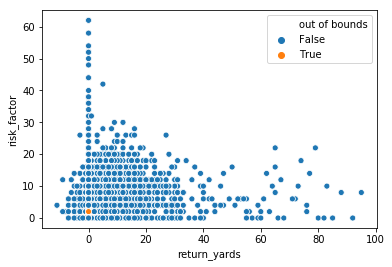

In [115]:
sns.scatterplot(x='return_yards', y='risk_factor', data=play_with_risk, hue='out of bounds')

In [104]:
play_with_risk.sort_values('risk_factor', ascending=False).to_csv('../working/play_with_risk_positions.csv')

In [207]:
play_with_risk['punt_yards_str'].head()

0    punts 51 yards to
1    punts 55 yards to
2    punts 49 yards to
3    punts 33 yards to
4    punts 42 yards to
Name: punt_yards_str, dtype: object

In [255]:
play_with_risk.loc[1103, 'punt_yards_str_short'] = '47'

In [299]:
play_with_risk['punt_yards_str_short'] = play_with_risk['punt_yards_str'] \
    .str.replace('punts ','') \
    .str.replace('yards','') \
    .str.replace('to','') \
    .str.replace('No yards', '0')

play_with_risk['punt_yards_str'] \
    = play_with_risk['playdescription'].str.extract('(punts .* yards to)', expand=True).fillna(False)
play_with_risk.loc[play_with_risk['punt_yards_str'] == False, 'punt_yards_str_short'] = 'No yards'
play_with_risk.loc[5149, 'punt_yards_str_short'] = '64'
play_with_risk.loc[10, 'punt_yards_str_short'] = '40'
play_with_risk.loc[1103, 'punt_yards_str_short'] = '47'
play_with_risk.loc[2918, 'punt_yards_str_short'] = '64'
play_with_risk.loc[5627, 'punt_yards_str_short'] = '62'
play_with_risk.loc[83, 'punt_yards_str_short'] = '63'
play_with_risk.loc[6435, 'punt_yards_str_short'] = '56'
play_with_risk.loc[3650, 'punt_yards_str_short'] = '50'
play_with_risk.loc[4671, 'punt_yards_str_short'] = '44'
play_with_risk.loc[665, 'punt_yards_str_short'] = '57'
play_with_risk.loc[5223, 'punt_yards_str_short'] = '35'
play_with_risk.loc[459, 'punt_yards_str_short'] = '46'
play_with_risk.loc[2480, 'punt_yards_str_short'] = '36'
play_with_risk.loc[4542, 'punt_yards_str_short'] = '22'
play_with_risk.loc[1057, 'punt_yards_str_short'] = '58'
play_with_risk['punt yards'] = play_with_risk['punt_yards_str_short'].replace('No yards', 0).astype('int')

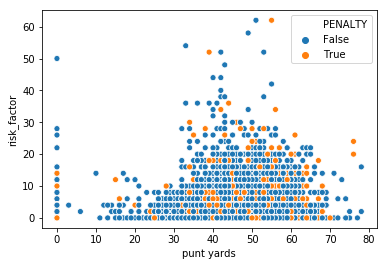

In [302]:
sns.scatterplot(x='punt yards', y='risk_factor', data=play_with_risk, hue='PENALTY')

In [308]:
vr['injury_play'] = True

In [311]:
play_with_risk = pd.merge(play_with_risk, vr, how='left').fillna(False)

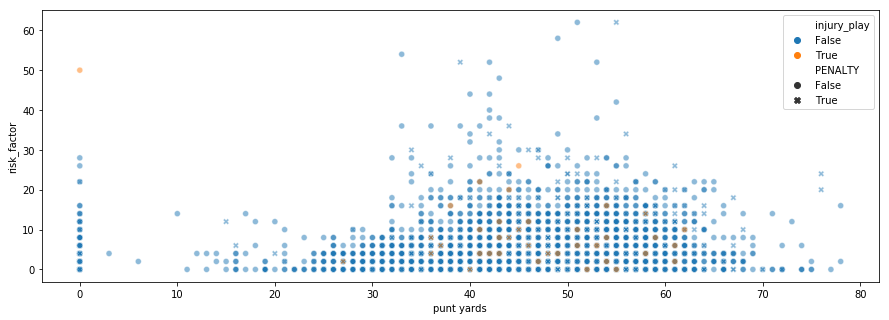

In [335]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x='punt yards',
                y='risk_factor',
                data=play_with_risk.sort_values('injury_play'),
                hue='injury_play', #linewidth=0,
                alpha=0.5,
               style='PENALTY', ax=ax)